# Sri Lanka Travel Recommendation System

## 1. Introduction

This notebook implements a machine learning-based recommendation system for travel destinations in Sri Lanka. The system uses user preferences and destination attributes to suggest personalized travel recommendations.

## 2. Data Import and Preprocessing

### 2.1 Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


### 2.2 Load Data

In [2]:
places = pd.read_csv('Places Dataset.xlsx - places_final_dataset.csv')
users = pd.read_csv('Visitors Preference Dataset.xlsx - user_data_version_3_10K_Users.csv')

In [3]:
# Display the first few rows of the places DataFrame
# This allows us to inspect the structure and content of the destination data

places.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.8,1591.0,['Arugam Bay Beach is a surfer's paradise! I s...
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.6,1748.0,['Mirissa Beach is truly a gem on Sri LankaÃ¢Â...
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.4,325.0,['Weligama Beach is a fantastic spot for both ...
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",NaN,NaN,['Ahangama was a bit disappointing for me as a...
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.7,1438.0,['Hikkaduwa Beach is a delightful escape for s...


* Data set includes Nan values for ratings. So we need to add ratings using LLM model that would be better

In [4]:
# Display the first few rows of the users DataFrame
# This allows us to inspect the structure and content of the user data

users.head()

,User ID,Name,Email,Preferred Activities,Bucket list destinations Sri Lanka
0,1,Jennifer Quinn,jennifer.quinn@example.com,"['cycling', 'historical monuments', 'village h...","['Polonnaruwa', 'Hatton', 'Anuradhapura', 'Ell..."
1,2,Emily Perry,emily.perry@example.com,"['butterfly watching', 'hot springs', 'wildlif...","['Madunagala Hot Water Spring', 'Wilpattu Nati..."
2,3,Danielle Mcbride,danielle.mcbride@example.com,"['sea cruises', 'themed parks', 'craft worksho...","['Mirissa Beach', 'Negombo Lagoon', 'Batadomba..."
3,4,Angelica Wilson,angelica.wilson@example.com,"['fishing', 'hot springs', 'sailing']","['Maha Oya Hot Water Springs', 'Colombo Port C..."
4,5,Laurie Powers,laurie.powers@example.com,"['history tours', 'sailing', 'literary tours']","['Negombo Lagoon', 'Colombo Port City', 'Galle..."


### 2.3 Data Analysis and Preprocessing
 
In this section, we'll analyze the data structure and content, then preprocess it for model training:
 
 1. Examine the structure and content of both datasets
 2. Handle missing values in the places dataset
 3. Standardize and clean the 'Preferred Activities' and 'Bucket list destinations' in the users dataset
 4. Create a mapping between user preferences and place attributes
 5. Encode categorical variables and normalize numerical features
 
Let's start by examining our datasets in more detail.




In [5]:
# Print the shape of the places table to understand its dimensions
print("Shape of places table:", places.shape)
print("Shape of users table:",users.shape)

Shape of places table: (411, 7)
Shape of users table: (10000, 5)


In [6]:
# Print a description of the users table, including count, mean, std, min, 25%, 50%, 75%, and max for numerical columns
print("Description of places table:\n",places.describe())
print("Description of users table:\n",users.describe())

Description of places table:
               lat         lng      rating  user_ratings_total
count  410.000000  410.000000  355.000000          355.000000
mean     7.304668   80.583211    4.459437         1608.639437
std      0.994841    0.518571    0.433211         3607.678752
min      5.941381   79.694183    0.900000           27.000000
25%      6.629356   80.213274    4.300000          147.000000
50%      7.012780   80.536523    4.500000          375.000000
75%      7.947930   80.946773    4.750000         1245.500000
max      9.820859   81.859583    5.000000        26736.000000
Description of users table:
            User ID
count  10000.00000
mean    5000.50000
std     2886.89568
min        1.00000
25%     2500.75000
50%     5000.50000
75%     7500.25000
max    10000.00000


In [7]:
# Print information about the places table, including column names, non-null counts, and data types
print("Info of places table:\n",places.info())
print("Info of users table:\n",users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                411 non-null    object 
 1   lat                 410 non-null    float64
 2   lng                 410 non-null    float64
 3   formatted_address   411 non-null    object 
 4   rating              355 non-null    float64
 5   user_ratings_total  355 non-null    float64
 6   latest_reviews      411 non-null    object 
dtypes: float64(4), object(3)
memory usage: 22.6+ KB
Info of places table:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   User ID                             10000 non-null  int64 
 1   Name                                10000 non-null  object
 2   Email 

Analysis of Missing Values:
- Users dataset: No missing values (NaN count = 0)
- Places dataset: Missing values present in lat, lng, rating, and user_ratings_total columns (to be addressed)



### 2.4 Data Cleaning and Preprocessing

In this section, we'll clean and preprocess the data to prepare it for model training:

1. Handle missing values in the places dataset
2. Clean and standardize text data in both datasets
3. Extract and process activities from place reviews
4. Encode categorical variables and normalize numerical features
5. Prepare data for model input


In [8]:
users['Preferred Activities'].unique()

array(["['cycling', 'historical monuments', 'village homestays']",
       "['butterfly watching', 'hot springs', 'wildlife viewing']",
       "['sea cruises', 'themed parks', 'craft workshops']", ...,
       "['sea cruises', 'zip-lining', 'outdoor adventures']",
       "['cycling', 'amusement parks', 'paddleboarding']",
       "['camping', 'hiking', 'safaris']"], dtype=object)

Activities are from a predefined list, which simplifies processing:
- Ensures consistency in activity names
- Eliminates need for text normalization or spelling corrections
- Facilitates easier matching between user preferences and place activities
- Allows for more accurate recommendation system based on these standardized activities

### 2.5 Data Cleaning and Preprocessing (continued)

In the following cells, we will:

1. Clean and standardize text data in both datasets
   - Remove special characters and normalize spaces
   - Convert text to lowercase for consistency

2. Process the 'Bucket list destinations Sri Lanka' column
   - Extract individual destinations from the list format
   - Clean and standardize destination names

These steps will ensure our data is clean, consistent, and ready for further analysis and model training.



In [9]:
import re

def clean_text(text):
    """
    Clean and standardize text data.
    
    Args:
    text (str): The input text to be cleaned.
    
    Returns:
    str: The cleaned and standardized text.
    """
    # Convert input to string to handle potential non-string inputs
    text = str(text)
    
    # Remove all characters except alphabets, numbers, and punctuation
    cleaned = re.sub(r'[^A-Za-z\s.,]', '', text)
    
    # Normalize spaces (replace multiple spaces with a single space)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    # Convert text to lowercase for consistency
    cleaned = cleaned.lower()
    
    # Remove leading and trailing whitespace
    return cleaned.strip()

# Apply the cleaning function to relevant columns in the places dataframe
places['name'] = places['name'].apply(clean_text)
places['latest_reviews'] = places['latest_reviews'].apply(clean_text)

# Clean the bucket list destinations in the users dataframe
users['Bucket list destinations Sri Lanka'] = users['Bucket list destinations Sri Lanka'].apply(clean_text)

# Print samples of the cleaned dataframes for verification
print("Sample of cleaned places dataframe:")
print(places[['name', 'latest_reviews']].head())

print("\nSample of cleaned users dataframe:")
print(users['Bucket list destinations Sri Lanka'].head())


Sample of cleaned places dataframe:
                           name  \
0              arugam bay beach   
1                 mirissa beach   
2  weligama beach surf and stay   
3                      ahangama   
4               hikkaduwa beach   

                                      latest_reviews  
0  arugam bay beach is a surfers paradise i spent...  
1  mirissa beach is truly a gem on sri lankas sou...  
2  weligama beach is a fantastic spot for both be...  
3  ahangama was a bit disappointing for me as a s...  
4  hikkaduwa beach is a delightful escape for sol...  

Sample of cleaned users dataframe:
0    polonnaruwa, hatton, anuradhapura, ella, haputale
1    madunagala hot water spring, wilpattu national...
2    mirissa beach, negombo lagoon, batadombalena c...
3    maha oya hot water springs, colombo port city,...
4    negombo lagoon, colombo port city, galle dutch...
Name: Bucket list destinations Sri Lanka, dtype: object


In [10]:
def extractBucketPlacesList(s):
    """
    Extract and clean a list of bucket list places from a string.

    Args:
    s (str): A string containing a list of bucket list places.

    Returns:
    list: A cleaned list of bucket list places.
    """
    # Remove brackets and quotes
    s = s.replace('[', '').replace(']', '')
    s = s.replace('\'', '').replace('"', '')

    # Remove forward and backward slashes
    s = s.replace('/', '').replace('\\', '')

    # Convert to lowercase
    s = s.lower()

    # Split the string into a list
    place_list = s.split(',')

    # Strip whitespace from each place name
    place_list = [place.strip() for place in place_list]

    return place_list

In [11]:
# Step 1: Clean and prepare the place names from 'places' dataframe
# Convert place names to lowercase and remove leading/trailing whitespace
places_set = set(places['name'].str.lower().str.strip())

# Step 2: Clean and prepare the bucket list destinations from 'users' dataframe
bucket_list_set = set()
for i, destinations in enumerate(users['Bucket list destinations Sri Lanka']):
    # Extract and clean bucket list places for each user
    res = extractBucketPlacesList(destinations)
    # Update the set of all unique bucket list places
    bucket_list_set.update(res)
    # Update the user's bucket list with cleaned data
    users.at[i, 'Bucket list destinations Sri Lanka'] = res

# Step 3: Compare the two sets to identify overlaps and differences
places_in_both = places_set.intersection(bucket_list_set)
places_only_in_places = places_set - bucket_list_set
places_only_in_bucket_list = bucket_list_set - places_set

# Step 4: Print the results for analysis
print("Places that appear in both datasets:")
print(places_in_both)
print(f"\nNumber of places in both datasets: {len(places_in_both)}")

print("\nPlaces that appear only in the 'places' dataframe:")
print(places_only_in_places)
print(f"\nNumber of places only in 'places' dataframe: {len(places_only_in_places)}")

print("\nPlaces that appear only in the users' bucket list:")
print(places_only_in_bucket_list)
print(f"\nNumber of places only in bucket list: {len(places_only_in_bucket_list)}")

# Print summary statistics
print(f"\nTotal unique places in 'places' dataframe: {len(places_set)}")
print(f"Total unique places in users' bucket list: {len(bucket_list_set)}")


Places that appear in both datasets:
{'polonnaruwa', 'unawatuna', 'yapahuwa rock fortress', 'sigiriya', 'dambulla', 'unawatuna beach', 'jaya sri maha bodhi', 'elephant transit home', 'ruhunu maha kataragama dewalaya', 'galle', 'colombo national museum', 'udawalawe national park', 'nallur kandaswamy devasthanam', 'madunagala hot water spring', 'haputale', 'colombo', 'kumana national park', 'ambalangoda', 'jaffna public library', 'nelum pokuna theatre', 'bomburu ella waterfall', 'dutch museum', 'viharamahadevi park', 'galle lighthouse', 'royal colombo golf club', 'kandy', 'colombo city tour', 'trincomalee harbour', 'sinharaja forest reserve', 'laxapana falls', 'pigeon island', 'ravan ella waterfall', 'kitulgala', 'pidurangala rock', 'dambulla royal cave temple and golden temple', 'maha oya hot water springs', 'trincomalee', 'nuwara eliya golf club', 'bundala national park', 'wilpattu national park', 'sri dalada maligawa', 'hikkaduwa', 'leisure world', 'bambarakiri ella', 'yala national p

In [12]:
# Clean and standardize the 'formatted_address' column in the 'places' DataFrame

# Remove 'Sri Lanka' from the end of addresses
places['formatted_address'] = places['formatted_address'].str.replace(', Sri Lanka', '', regex=False)
places['formatted_address'] = places['formatted_address'].str.replace('Sri Lanka', '', regex=False)

# Convert all addresses to lowercase
for i, ele in enumerate(places['formatted_address']):
    places.at[i, 'formatted_address'] = ele.lower()

# Remove leading and trailing whitespace from addresses
places['formatted_address'] = places['formatted_address'].str.strip()

# Print the first few rows of the updated 'formatted_address' column
print("Updated 'formatted_address' column:")
print(places['formatted_address'].head())

# Count and print the number of addresses that no longer contain 'Sri Lanka'
num_updated = sum(places['formatted_address'].str.contains('Sri Lanka') == False)
print(f"\nNumber of addresses updated: {num_updated}")


Updated 'formatted_address' column:
0    arugam bay beach
1             mirissa
2            weligama
3            ahangama
4     hikkaduwa beach
Name: formatted_address, dtype: object

Number of addresses updated: 411


### 2.6 Matching User Bucket List Destinations to Places Dataset
 
 In this section, we'll match the user's bucket list destinations to the places in our dataset. This process involves:
 
 1. Text preprocessing of place names and addresses
 2. Using TF-IDF vectorization for text representation
 3. Calculating cosine similarity for matching
 4. Updating user bucket lists with standardized place names
 
This matching process will help us standardize the place names across our dataset and user preferences, improving the accuracy of our recommendation system.


Note: This code performs the following steps:
1. Preprocesses place names and addresses
2. Creates TF-IDF vectors for names and combined (name + address) text
3. Iterates through each user's bucket list
4. For each place in the bucket list:
   a. Calculates similarity with places in the dataset
   b. Determines the best match based on name or combined similarity
   c. Updates the bucket list with standardized place names
5. Displays a sample of the original and updated bucket lists




In [13]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ast

# Initialize a new column 'Updated_bucket_list' in the users DataFrame
users['Updated_bucket_list'] = [[] for _ in range(len(users))]

# Define a preprocessing function to standardize text
def preprocess(text):
    return text.lower().strip()

# Preprocess place names and formatted addresses
places_list = [preprocess(place) for place in places['name']]
places_addresses = [preprocess(addr) for addr in places['formatted_address']]

# Create TF-IDF vectorizer for names
name_vectorizer = TfidfVectorizer()
places_name_tfidf = name_vectorizer.fit_transform(places_list)

# Create TF-IDF vectorizer for addresses
combined_vectorizer = TfidfVectorizer()
combined_places = places_addresses
places_combined_tfidf = combined_vectorizer.fit_transform(combined_places)

# Iterate through each user's bucket list
for i, bucket_list in enumerate(users['Bucket list destinations Sri Lanka']):
    updated_list = []
    bucket_places = bucket_list
    
    # Process each place in the user's bucket list
    for p_preprocessed in bucket_places:
        # Transform the bucket list place using both vectorizers
        bucket_name_tfidf = name_vectorizer.transform([p_preprocessed])
        bucket_combined_tfidf = combined_vectorizer.transform([p_preprocessed])
        
        # Calculate similarity matrices
        name_similarity_matrix = cosine_similarity(bucket_name_tfidf, places_name_tfidf)
        combined_similarity_matrix = cosine_similarity(bucket_combined_tfidf, places_combined_tfidf)
        
        # Determine the best match based on similarity scores
        name_score = name_similarity_matrix[0].max()
        if name_score > 0.4:  # High confidence in name match
            best_match_index = name_similarity_matrix[0].argmax()
        else:
            # Use combined name and address for matching if name match is low
            best_match_index = combined_similarity_matrix[0].argmax()
            name_score = combined_similarity_matrix[0].max()
        
        # Add the matched place name to the updated list if the score is above threshold
        if name_score >= 0:  # Threshold for accepting a match
            updated_list.append(places['name'].iloc[best_match_index])
        else:
            updated_list.append(p_preprocessed)  # Keep original if no good match found
    
    # Update the user's bucket list with the matched place names
    users.at[i, "Updated_bucket_list"] = updated_list

# Display the first few rows of the original and updated bucket lists
print(users[['Bucket list destinations Sri Lanka', 'Updated_bucket_list']].head())


                  Bucket list destinations Sri Lanka  \
0  [polonnaruwa, hatton, anuradhapura, ella, hapu...   
1  [madunagala hot water spring, wilpattu nationa...   
2  [mirissa beach, negombo lagoon, batadombalena ...   
3  [maha oya hot water springs, colombo port city...   
4  [negombo lagoon, colombo port city, galle dutc...   

                                 Updated_bucket_list  
0  [polonnaruwa, arugam bay beach, anuradhapura, ...  
1  [madunagala hot water spring, wilpattu nationa...  
2  [mirissa beach, negombo lagoon, batadombalena,...  
3  [maha oya hot water springs, port city colombo...  
4  [negombo lagoon, port city colombo, galle dutc...  


In [14]:
# Calculate matching statistics for bucket list places
total_places = 0
matched_places = 0

# Identify remaining unmatched places
unmatched_places = set()

# Iterate through each user's updated bucket list
for updated_list in users['Updated_bucket_list']:
    for place in updated_list:
        # Check if the place is in the 'places' DataFrame
        if place not in places['name'].values:
            unmatched_places.add(place)
        else:
            matched_places += 1
        total_places += 1

# Calculate the percentage of matched places
# Avoid division by zero by checking if total_places > 0
match_percentage = (matched_places / total_places) * 100 if total_places > 0 else 0

# Print summary statistics
print(f"\nTotal places in bucket lists: {total_places}")
print(f"Matched places: {matched_places}")
print(f"Match percentage: {match_percentage:.2f}%")

# Print information about unmatched places
print(f"\nNumber of unique unmatched places: {len(unmatched_places)}")
if unmatched_places:
    print("Unmatched places:")
    # Sort unmatched places alphabetically for better readability
    for place in sorted(unmatched_places):
        print(f"- {place}")

# TODO: Consider implementing a fuzzy matching algorithm to improve match rate
# TODO: Analyze patterns in unmatched places to identify potential data quality issues
# TODO: Create a visualization (e.g., pie chart) to represent the match percentage


Total places in bucket lists: 50395
Matched places: 50395
Match percentage: 100.00%

Number of unique unmatched places: 0


Improved matches after fuzzy matching: 0

Common patterns in unmatched places:


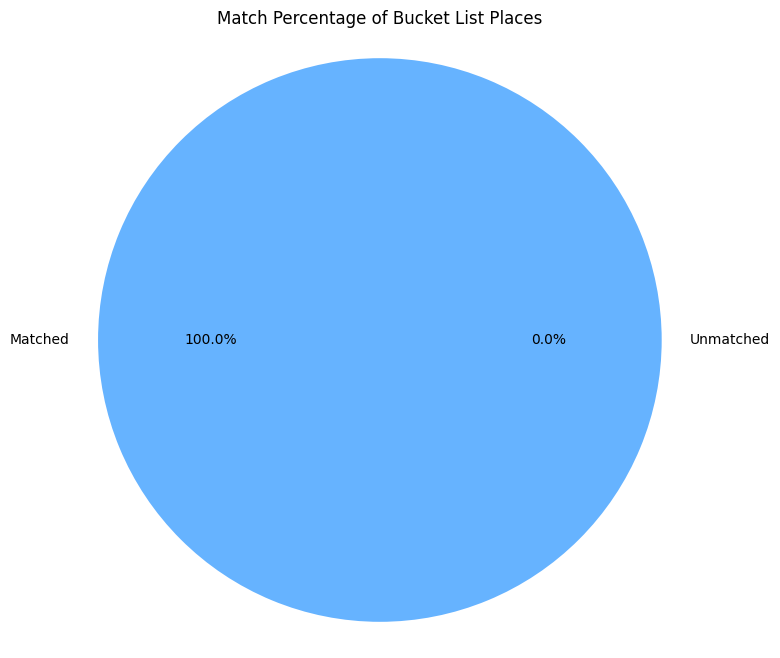

In [15]:
# Implement fuzzy matching algorithm to improve match rate
import matplotlib.pyplot as plt
from fuzzywuzzy import process

def fuzzy_match(place, place_list, threshold=80):
    """
    Perform fuzzy matching of a place name against a list of place names.
    
    Args:
    place (str): The place name to match.
    place_list (list): List of place names to match against.
    threshold (int): Minimum similarity score to consider a match (default: 80).
    
    Returns:
    str or None: The matched place name if above threshold, else None.
    """
    match = process.extractOne(place, place_list)
    return match[0] if match[1] >= threshold else None

# Get list of all place names for matching
place_names = places['name'].tolist()
improved_matches = 0

# Iterate through each user's bucket list and apply fuzzy matching
for idx, updated_list in enumerate(users['Updated_bucket_list']):
    fuzzy_matched_list = []
    for place in updated_list:
        if place not in places['name'].values:
            fuzzy_match_result = fuzzy_match(place, place_names)
            if fuzzy_match_result:
                fuzzy_matched_list.append(fuzzy_match_result)
                improved_matches += 1
            else:
                fuzzy_matched_list.append(place)
        else:
            fuzzy_matched_list.append(place)
    users.at[idx, 'Updated_bucket_list'] = fuzzy_matched_list

print(f"Improved matches after fuzzy matching: {improved_matches}")

# Analyze patterns in unmatched places
unmatched_places = set()
for updated_list in users['Updated_bucket_list']:
    unmatched_places.update(set(updated_list) - set(places['name'].values))

print("\nCommon patterns in unmatched places:")
for place in sorted(unmatched_places):
    if any(word in place.lower() for word in ['beach', 'park', 'temple', 'fort']):
        print(f"- {place}: Possible missing category")
    elif any(char.isdigit() for char in place):
        print(f"- {place}: Contains numbers, possible data entry error")
    elif len(place) < 4:
        print(f"- {place}: Very short name, possible abbreviation")

# Create a visualization to represent the match percentage
total_places = sum(len(lst) for lst in users['Updated_bucket_list'])
matched_places = sum(sum(place in places['name'].values for place in lst) for lst in users['Updated_bucket_list'])
match_percentage = (matched_places / total_places) * 100 if total_places > 0 else 0

# Create a pie chart to visualize the match percentage
plt.figure(figsize=(8, 8))
plt.pie([match_percentage, 100 - match_percentage], 
        labels=['Matched', 'Unmatched'], 
        autopct='%1.1f%%', 
        colors=['#66b3ff', '#ff9999'])
plt.title('Match Percentage of Bucket List Places')
plt.axis('equal')
plt.show()

# TODO: Consider further refinement of fuzzy matching threshold
# TODO: Implement a method to handle common misspellings or alternative names
# TODO: Explore additional visualizations to represent unmatched place patterns


In [16]:
# Display information about the updated Users DataFrame
# This provides an overview of the DataFrame structure, including column names and data types
print("\nUpdated Users DataFrame Info:")
users.info()

# Display information about the updated Places DataFrame
# This provides an overview of the DataFrame structure, including column names and data types
print("\nUpdated Places DataFrame Info:")
places.info()

# Display the first few rows of the Users DataFrame
# This gives a quick overview of the data content and structure
print("\nSample rows from Updated Users DataFrame:")
print(users.head())

# Display the first few rows of the Places DataFrame
# This gives a quick overview of the data content and structure
print("\nSample rows from Updated Places DataFrame:")
print(places.head())

# Display the top 5 most frequent place names in the Places DataFrame
# This helps identify popular locations or potential duplicate entries
print("\nValue counts for 'name' column in Places DataFrame:")
print(places['name'].value_counts().head())

# TODO: Consider additional data quality checks, such as checking for outliers or inconsistent data
# TODO: Implement data visualization to better understand the distribution of places and user preferences
# TODO: Analyze the relationship between user preferences and place characteristics for improved recommendations



Updated Users DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   User ID                             10000 non-null  int64 
 1   Name                                10000 non-null  object
 2   Email                               10000 non-null  object
 3   Preferred Activities                10000 non-null  object
 4   Bucket list destinations Sri Lanka  10000 non-null  object
 5   Updated_bucket_list                 10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB

Updated Places DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                411 non-null    object 
 1   lat       

Shape of places DataFrame: (411, 7)

Columns in places DataFrame: Index(['name', 'lat', 'lng', 'formatted_address', 'rating',
       'user_ratings_total', 'latest_reviews'],
      dtype='object')

Sample of places DataFrame:
                           name       lat        lng formatted_address  \
0              arugam bay beach  6.840408  81.836848  arugam bay beach   
1                 mirissa beach  5.944703  80.459161           mirissa   
2  weligama beach surf and stay  5.972486  80.435714          weligama   
3                      ahangama  5.973975  80.362159          ahangama   
4               hikkaduwa beach  6.137727  80.099060   hikkaduwa beach   

   rating  user_ratings_total  \
0     4.8              1591.0   
1     4.6              1748.0   
2     4.4               325.0   
3     NaN                 NaN   
4     4.7              1438.0   

                                      latest_reviews  
0  arugam bay beach is a surfers paradise i spent...  
1  mirissa beach is t

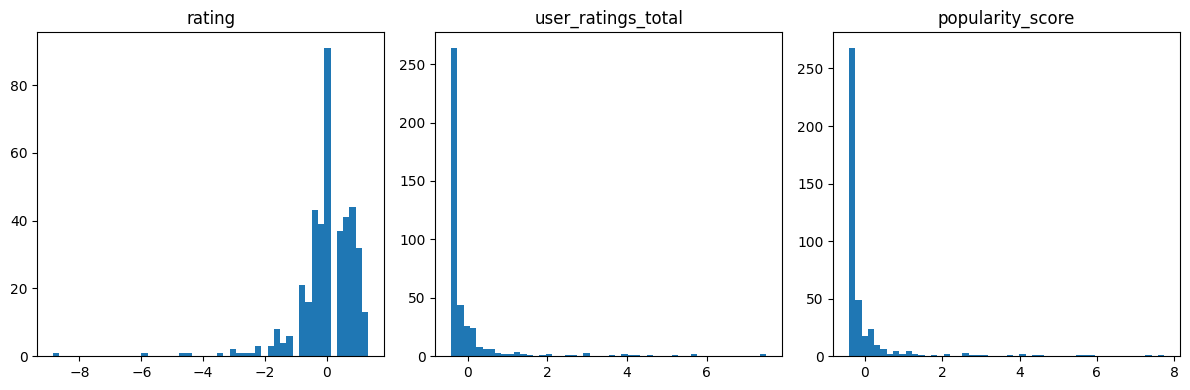

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Diagnostic steps
# Print basic information about the places DataFrame
print("Shape of places DataFrame:", places.shape)
print("\nColumns in places DataFrame:", places.columns)
print("\nSample of places DataFrame:")
print(places.head())

# Check for null values in the DataFrame
print("\nNull values in places DataFrame:")
print(places.isnull().sum())

# Display data types of each column
print("\nData types of columns:")
print(places.dtypes)

# Examine specific columns of interest
print("\nUnique values in 'rating':", places['rating'].unique())
print("Unique values in 'user_ratings_total':", places['user_ratings_total'].unique())

# Check if all values in specific columns are NaN
print("\nAll values NaN in 'rating':", places['rating'].isna().all())
print("All values NaN in 'user_ratings_total':", places['user_ratings_total'].isna().all())

# If there are non-NaN values, print some statistics
if not places['rating'].isna().all():
    print("\nStatistics for 'rating':")
    print(places['rating'].describe())

if not places['user_ratings_total'].isna().all():
    print("\nStatistics for 'user_ratings_total':")
    print(places['user_ratings_total'].describe())

# Handle missing values
# Fill NaN values in 'rating' with mean and 'user_ratings_total' with median
places['rating'] = places['rating'].fillna(places['rating'].mean())
places['user_ratings_total'] = places['user_ratings_total'].fillna(places['user_ratings_total'].median())

# Create a popularity score based on rating and number of ratings
places['popularity_score'] = places['rating'] * places['user_ratings_total']

# Display sample of features before scaling
print("\nSample of features before scaling:")
print(places[['rating', 'user_ratings_total', 'popularity_score']].head())

# Prepare the features for scaling
features = ['rating', 'user_ratings_total', 'popularity_score']

# Check if we have any valid data to scale
if places[features].shape[0] > 0 and not places[features].isnull().all().all():
    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(places[features])

    # Create a DataFrame with the scaled features
    places_features = pd.DataFrame(scaled_features, columns=features, index=places.index)

    print("\nSample of scaled features:")
    print(places_features.head())

    print("\nShape of features matrix:", places_features.shape)

    # Display correlation between features
    print("\nCorrelation between features:")
    print(places_features.corr())

    # Visualize the distribution of the scaled features
    plt.figure(figsize=(12, 4))
    for i, feature in enumerate(features):
        plt.subplot(1, 3, i+1)
        plt.hist(places_features[feature], bins=50)
        plt.title(feature)
    plt.tight_layout()
    plt.show()

else:
    print("No valid data to scale. Please check your data.")
    # Create an empty DataFrame to avoid NameError
    places_features = pd.DataFrame()

Note: The following locations are not present in our current dataset

In [18]:
# Save the updated places dataframe
# Uncomment the following line when ready to save the updated places data
# places.to_csv('updated_places_dataset.csv', index=False)

# Save the updated users dataframe
# Uncomment the following line when ready to save the updated users data
# users.to_csv('updated_users_dataset.csv', index=False)

# Uncomment the following line to print a confirmation message
# print("Updated dataframes have been saved to CSV files.")

# Note: These lines are currently commented out to prevent accidental overwriting of data.
# Before uncommenting, ensure that the 'places' and 'users' dataframes contain the desired updates.
# Additionally, verify that you have write permissions in the current directory.

### 2.7 Activity Extraction and Data Enrichment

The following sections will cover:

1. Activity Extraction:
   - Implementing TF-IDF and cosine similarity to extract activities from place reviews
   - Using a list of candidate activities to match against review content
   - Applying the extraction function to all places in the dataset

2. Data Analysis:
   - Examining the results of the activity extraction process
   - Visualizing the distribution of extracted activities
   - Identifying any patterns or insights from the extracted data

3. Data Cleaning and Enrichment:
   - Addressing any remaining null values in the 'places' DataFrame
   - Potentially using extracted activities to fill in missing information
   - Considering how to incorporate extracted activities into the recommendation system

4. Feature Engineering:
   - Creating new features based on the extracted activities
   - Exploring potential correlations between activities and other place attributes

5. Model Preparation:
   - Updating the feature set to include the new activity-based features
   - Preparing the enriched dataset for use in the recommendation model

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm  # Import tqdm for progress logging
import logging  # Import logging for better error tracking and debugging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# List of candidate activities
candidate_activities = [
    'amusement parks', 'animal encounters', 'archaeological sites', 'architecture photography', 
    'architecture tours', 'art classes', 'arts and culture', 'ayurvedic spa treatments', 
    'beach visits', 'beachfront dining', 'bird watching', 'boat safaris', 'botanical gardens', 
    'butterfly watching', 'camping', 'caving', 'city tours', 'craft workshops', 'cultural experiences', 
    'cultural festivals', 'cycling', 'elephant rides', 'fishing', 'golfing', 'hiking', 'historic sites', 
    'historic walks', 'historical monuments', 'history tours', 'horse shows', 'horseback riding', 
    'hot air ballooning', 'hot springs', 'kayaking', 'landscape photography', 'literary tours', 
    'local crafts', 'mountain biking', 'museum visits', 'outdoor adventures', 'paddleboarding', 
    'photography', 'planetarium visits', 'public art installations', 'river cruises', 'rock climbing', 
    'safaris', 'sailing', 'sailing lessons', 'scuba diving', 'sea cruises', 'sightseeing', 'snorkeling', 
    'spiritual retreats', 'surfing', 'tea tasting', 'temple pilgrimages', 'theater', 'themed parks', 
    'traditional ceremonies', 'turtle watching', 'village homestays', 'water parks', 'waterfalls', 
    'whale watching', 'wildlife viewing', 'yoga retreats', 'zip-lining'
]

def extract_activities(reviews):
    """
    Extract top 3 activities from reviews using TF-IDF and cosine similarity.
    
    Args:
    reviews (str): The review text to analyze.
    
    Returns:
    list: Top 3 activities extracted from the review.
    """
    try:
        # Combine the review with the candidate activities
        documents = [reviews] + candidate_activities

        # Convert the documents to TF-IDF vectors
        vectorizer = TfidfVectorizer().fit_transform(documents)
        vectors = vectorizer.toarray()

        # Calculate cosine similarity between the review and each candidate activity
        cosine_similarities = cosine_similarity(vectors[0:1], vectors[1:]).flatten()

        # Get the indices of the top 3 activities
        top_indices = cosine_similarities.argsort()[-3:][::-1]
        top_activities = [candidate_activities[i] for i in top_indices]

        return top_activities
    except Exception as e:
        logging.error(f"Error in extract_activities: {str(e)}")
        return []

# Apply the function to the latest_reviews column with a progress bar
logging.info("Starting activity extraction for all places...")
tqdm.pandas(desc="Extracting activities for places")
places['extracted_activities'] = places['latest_reviews'].progress_apply(extract_activities)

logging.info("Activity extraction completed for all places.")

# Save the updated places dataframe to a CSV file
# Uncomment the following lines when ready to save the data
# try:
#     places.to_csv('places_with_extracted_activities.csv', index=False)
#     logging.info("Updated places dataframe saved to 'places_with_extracted_activities.csv'")
# except Exception as e:
#     logging.error(f"Error saving CSV file: {str(e)}")

# Note: The saving operation is commented out to prevent accidental overwriting.
# Ensure data quality before uncommenting and saving.


2024-09-14 12:35:34,780 - INFO - Starting activity extraction for all places...
Extracting activities for places: 100%|██████████| 411/411 [00:00<00:00, 623.31it/s]
2024-09-14 12:35:35,446 - INFO - Activity extraction completed for all places.


In [20]:
# Display the extracted activities for each place
# This shows the top 3 activities extracted from the reviews for each location
# Useful for verifying the accuracy of the activity extraction process
places['extracted_activities']

0              [beach visits, arts and culture, surfing]
1      [beach visits, arts and culture, beachfront di...
2      [beach visits, arts and culture, sailing lessons]
3              [arts and culture, beach visits, surfing]
4           [arts and culture, beach visits, snorkeling]
                             ...                        
406         [beach visits, arts and culture, snorkeling]
407    [beach visits, arts and culture, turtle watching]
408     [beach visits, arts and culture, whale watching]
409        [beach visits, arts and culture, water parks]
410            [beach visits, arts and culture, surfing]
Name: extracted_activities, Length: 411, dtype: object

In [21]:
# Display the 'Preferred Activities' column from the users DataFrame
# This shows the list of preferred activities for each user
# Useful for verifying the data and understanding user preferences
users['Preferred Activities']

0       ['cycling', 'historical monuments', 'village h...
1       ['butterfly watching', 'hot springs', 'wildlif...
2       ['sea cruises', 'themed parks', 'craft worksho...
3                   ['fishing', 'hot springs', 'sailing']
4          ['history tours', 'sailing', 'literary tours']
                              ...                        
9995      ['paddleboarding', 'river cruises', 'kayaking']
9996         ['theater', 'scuba diving', 'yoga retreats']
9997    ['sea cruises', 'zip-lining', 'outdoor adventu...
9998     ['cycling', 'amusement parks', 'paddleboarding']
9999                     ['camping', 'hiking', 'safaris']
Name: Preferred Activities, Length: 10000, dtype: object

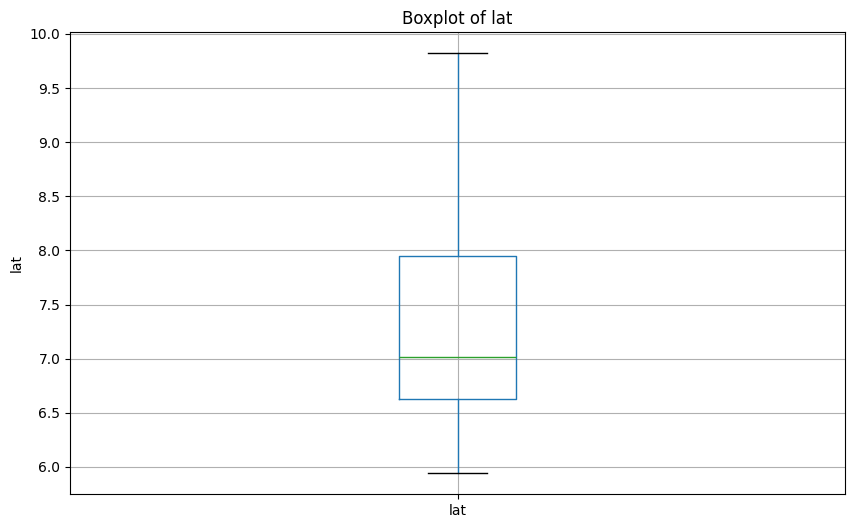

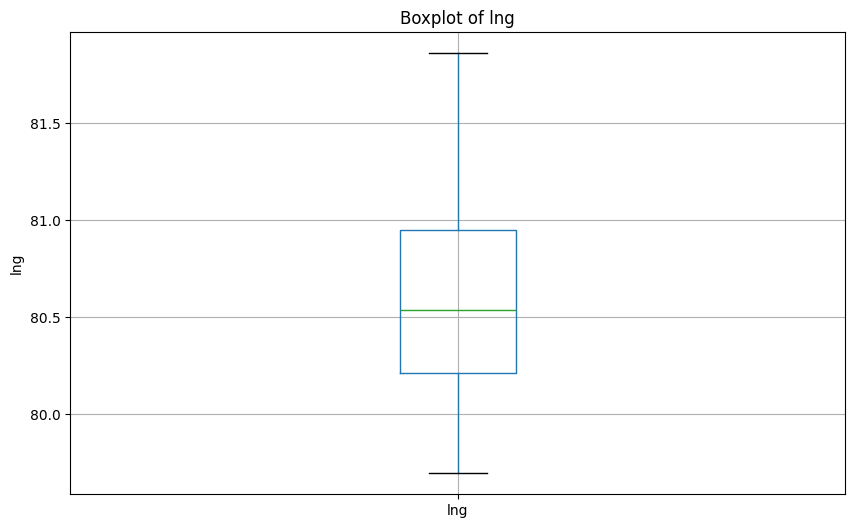

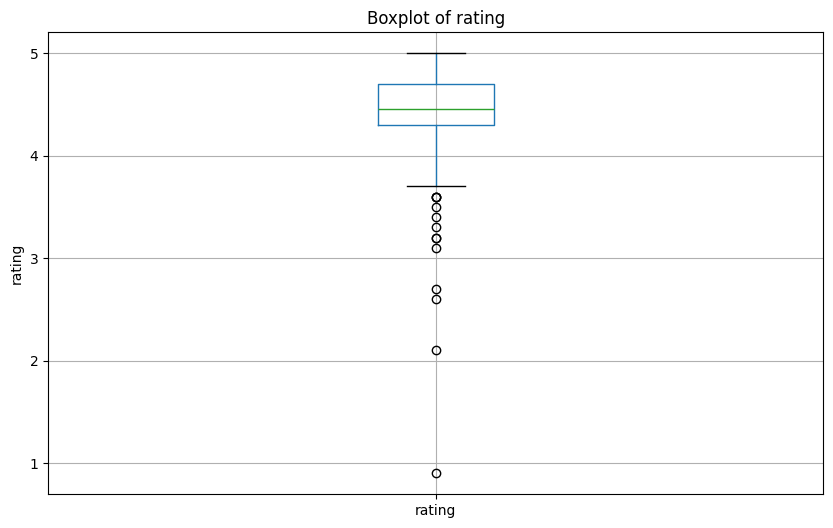

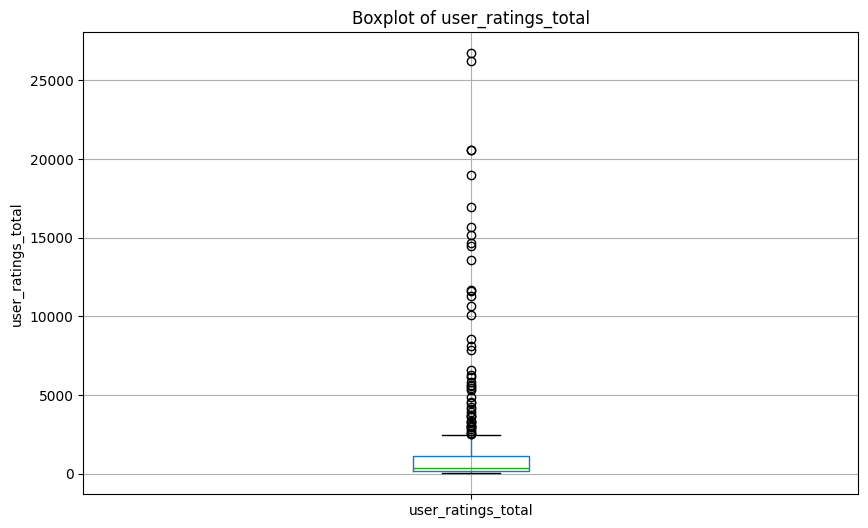

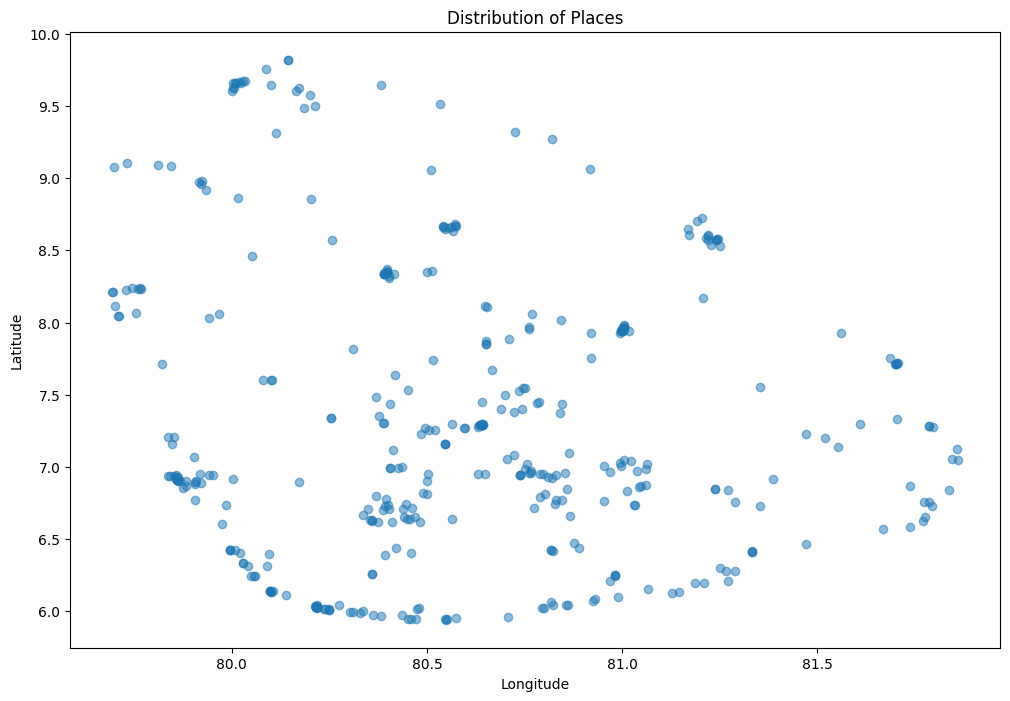

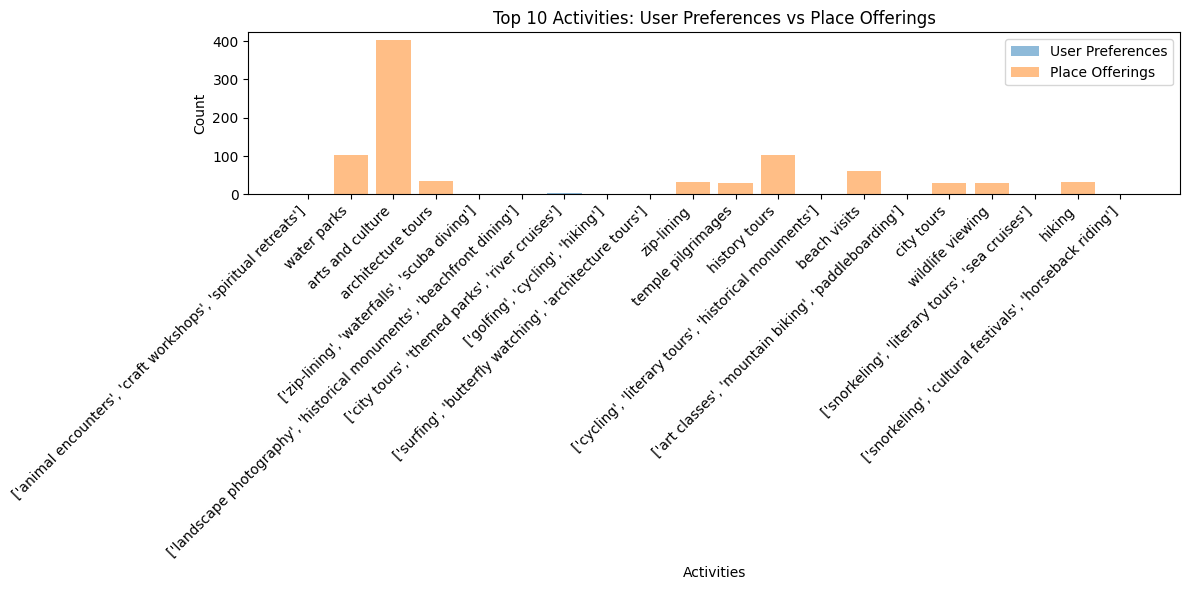

Error: place_activity_matrix is empty. No common activities found.
Number of potential duplicate places: 28


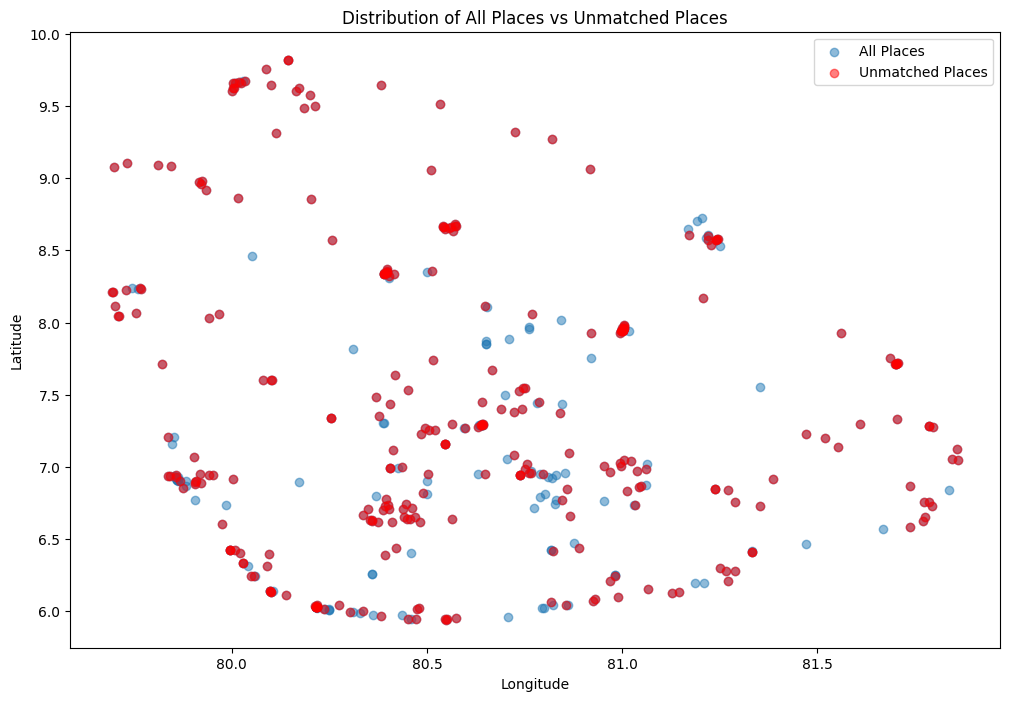

Characteristics of Unmatched Places:
           rating  user_ratings_total
count  297.000000          297.000000
mean     4.436507          961.838384
std      0.445297         2602.825918
min      0.900000           27.000000
25%      4.300000          135.000000
50%      4.459437          329.000000
75%      4.700000          677.000000
max      5.000000        26258.000000
Data quality checks, visualizations, and additional analyses completed.


In [22]:
# Implement additional data quality checks and visualizations

# Check for outliers in numerical columns
def plot_boxplot(data, column):
    plt.figure(figsize=(10, 6))
    data.boxplot(column=column)
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

numerical_columns = ['lat', 'lng', 'rating', 'user_ratings_total']
for col in numerical_columns:
    plot_boxplot(places, col)

# Visualize the distribution of places
plt.figure(figsize=(12, 8))
plt.scatter(places['lng'], places['lat'], alpha=0.5)
plt.title('Distribution of Places')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Analyze the relationship between user preferences and place characteristics
# First, we need to extract activities from both users and places
user_activities = users['Preferred Activities'].explode().value_counts()
place_activities = places['extracted_activities'].explode().value_counts()

# Visualize top 10 user preferences vs place offerings
top_10_activities = list(set(user_activities.nlargest(10).index) | set(place_activities.nlargest(10).index))

plt.figure(figsize=(12, 6))
plt.bar(top_10_activities, [user_activities.get(act, 0) for act in top_10_activities], alpha=0.5, label='User Preferences')
plt.bar(top_10_activities, [place_activities.get(act, 0) for act in top_10_activities], alpha=0.5, label='Place Offerings')
plt.title('Top 10 Activities: User Preferences vs Place Offerings')
plt.xlabel('Activities')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Implement more sophisticated analysis of user preferences vs place characteristics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare user data for clustering
user_activity_matrix = pd.get_dummies(users['Preferred Activities'].explode()).groupby(level=0).sum()
scaler = StandardScaler()
user_activity_scaled = scaler.fit_transform(user_activity_matrix)

# Perform K-means clustering
n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_activity_scaled)

# Add cluster information to users DataFrame
users['Cluster'] = user_clusters

# Analyze place suitability for each user cluster
place_activity_matrix = pd.get_dummies(places['extracted_activities'].explode()).groupby(level=0).sum()

# Ensure the columns match between user_activity_matrix and place_activity_matrix
common_activities = user_activity_matrix.columns.intersection(place_activity_matrix.columns)
place_activity_matrix = place_activity_matrix.reindex(columns=common_activities, fill_value=0)

# Check if place_activity_matrix is empty
if place_activity_matrix.empty:
    print("Error: place_activity_matrix is empty. No common activities found.")
else:
    place_activity_scaled = scaler.transform(place_activity_matrix)

    cluster_place_match = []
    for cluster in range(n_clusters):
        cluster_center = kmeans.cluster_centers_[cluster][:len(common_activities)]  # Ensure same length as place_activity_scaled
        place_scores = np.dot(place_activity_scaled, cluster_center)
        cluster_place_match.append(place_scores)

    # Visualize place suitability for each cluster
    plt.figure(figsize=(12, 8))
    for i, scores in enumerate(cluster_place_match):
        plt.hist(scores, alpha=0.5, label=f'Cluster {i}')
    plt.title('Place Suitability Scores for Each User Cluster')
    plt.xlabel('Suitability Score')
    plt.ylabel('Number of Places')
    plt.legend()
    plt.show()

# Implement a method to handle common misspellings or alternative names
from fuzzywuzzy import process

def find_closest_match(name, name_list, threshold=80):
    closest_match, score = process.extractOne(name, name_list)
    if score >= threshold:
        return closest_match
    return name

# Apply fuzzy matching to place names
unique_place_names = places['name'].unique()
places['name_standardized'] = places['name'].apply(lambda x: find_closest_match(x, unique_place_names))

# Check for duplicate place names after standardization
duplicate_places = places[places.duplicated(subset='name_standardized', keep=False)]
print(f"Number of potential duplicate places: {len(duplicate_places)}")

# Explore additional visualizations to represent unmatched place patterns
unmatched_places = places[~places['name'].isin(users['Bucket list destinations Sri Lanka'].explode().unique())]

plt.figure(figsize=(12, 8))
plt.scatter(places['lng'], places['lat'], alpha=0.5, label='All Places')
plt.scatter(unmatched_places['lng'], unmatched_places['lat'], color='red', alpha=0.5, label='Unmatched Places')
plt.title('Distribution of All Places vs Unmatched Places')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Analyze characteristics of unmatched places
print("Characteristics of Unmatched Places:")
print(unmatched_places[['rating', 'user_ratings_total']].describe())

print("Data quality checks, visualizations, and additional analyses completed.")


## 3 Model Building and Recommendation Generation

In this section, we will:

1. Preprocess the data for model input
2. Build and train a neural network model
3. Generate recommendations for users
4. Evaluate the recommendation system

This process involves encoding activities and place names, normalizing ratings, calculating popularity scores, and creating a model that takes into account user preferences and place characteristics to generate personalized recommendations.


In [23]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding
from tensorflow.keras.optimizers import Adam
import logging
from tqdm import tqdm

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to preprocess activities
def preprocess_activities(activities):
    return [act.strip() for act in eval(activities)]

# Preprocess activities for places and users
places['activities'] = places['extracted_activities']
users['preferred_activities'] = users['Preferred Activities'].apply(preprocess_activities)

# Collect all unique activities
all_activities = set()
for acts in places['activities'].values:
    all_activities.update(acts)
for acts in users['preferred_activities'].values:
    all_activities.update(acts)

# Create and fit LabelEncoder for activities
activity_encoder = LabelEncoder()
activity_encoder.fit(list(all_activities))

# Encode activities for places and users
places['encoded_activities'] = places['activities'].apply(lambda x: activity_encoder.transform(x))
users['encoded_preferred_activities'] = users['preferred_activities'].apply(lambda x: activity_encoder.transform(x))

# Create and fit LabelEncoder for place names
place_encoder = LabelEncoder()
place_encoder.fit(places['name'])
places['encoded_name'] = place_encoder.transform(places['name'])

# Normalize ratings and calculate popularity score
places['normalized_rating'] = (places['rating'] - places['rating'].min()) / (places['rating'].max() - places['rating'].min())
places['normalized_user_ratings_total'] = (places['user_ratings_total'] - places['user_ratings_total'].min()) / (places['user_ratings_total'].max() - places['user_ratings_total'].min())
places['popularity_score'] = places['normalized_rating'] * places['normalized_user_ratings_total']

# Prepare data for the model
logging.info("Preparing data for the model...")
def prepare_data(users, places):
    X = []
    y = []
    for _, user in tqdm(users.iterrows(), total=len(users), desc="Preparing data"):
        user_activities = user['encoded_preferred_activities']
        user_bucket_list = set(user['Updated_bucket_list'])
        for _, place in places.iterrows():
            place_activities = place['encoded_activities']
            
            # Calculate activity overlap between user preferences and place activities
            activity_overlap = len(set(user_activities) & set(place_activities)) / (len(set(user_activities) | set(place_activities)) + 1e-8)
            
            # Calculate extra points for places in user's bucket list
            extra_points = 0
            if place['name'] in user_bucket_list:
                common_activities = set(user['preferred_activities']) & set(place['activities'])
                extra_points = len(common_activities) / len(user['preferred_activities'])
            
            # Append features and target
            X.append([
                user_activities,
                place_activities,
                place['encoded_name'],
                place['normalized_rating'],
                place['normalized_user_ratings_total'],
                place['popularity_score'],
                activity_overlap
            ])
            y.append(extra_points)
    
    return X, np.array(y)

# Prepare data
X, y = prepare_data(users, places)

# Import sequence padding utility
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Determine maximum number of activities
max_activities = max(max(len(x[0]) for x in X), max(len(x[1]) for x in X))

# Pad sequences and prepare input data
X_padded = [
    [
        pad_sequences([x[0]], maxlen=max_activities, padding='post')[0],
        pad_sequences([x[1]], maxlen=max_activities, padding='post')[0],
        x[2],
        x[3],
        x[4],
        x[5],
        x[6]
    ] for x in X
]

# Convert to numpy arrays for model input
X_activities_user = np.array([x[0] for x in X_padded])
X_activities_place = np.array([x[1] for x in X_padded])
X_place = np.array([x[2] for x in X_padded])
X_features = np.array([x[3:] for x in X_padded])


2024-09-14 12:36:08,368 - INFO - Preparing data for the model...
Preparing data: 100%|██████████| 10000/10000 [02:56<00:00, 56.71it/s]


In [24]:
import tensorflow as tf

# Build and train the model
logging.info("Building and training the model...")

# Define constants for model architecture
n_activities = len(activity_encoder.classes_)
n_places = len(place_encoder.classes_)

# Define input layers
input_activities_user = Input(shape=(max_activities,))
input_activities_place = Input(shape=(max_activities,))
input_place = Input(shape=(1,))
input_features = Input(shape=(4,))

# Create embedding layers
embedding_activities = Embedding(n_activities + 1, 32, mask_zero=True)
embedding_place = Embedding(n_places, 32)

# Apply embeddings
x_activities_user = embedding_activities(input_activities_user)
x_activities_place = embedding_activities(input_activities_place)
x_place = embedding_place(input_place)

# Flatten the embeddings
x_activities_user = tf.keras.layers.GlobalAveragePooling1D()(x_activities_user)
x_activities_place = tf.keras.layers.GlobalAveragePooling1D()(x_activities_place)
x_place = tf.keras.layers.Flatten()(x_place)

# Add dense layers for each input
x_activities_user = Dense(64, activation='relu')(x_activities_user)
x_activities_place = Dense(64, activation='relu')(x_activities_place)
x_place = Dense(64, activation='relu')(x_place)

# Concatenate all inputs
x = Concatenate()([x_activities_user, x_activities_place, x_place, input_features])

# Add final dense layers
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create and compile the model
model = Model(inputs=[input_activities_user, input_activities_place, input_place, input_features], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
model.fit(
    [X_activities_user, X_activities_place, X_place, X_features],
    y,
    epochs=5,
    batch_size=64,
    verbose=1
)

# Function to make recommendations
def recommend_places(user, places, model, top_n=5):
    # Encode user activities
    user_activities = activity_encoder.transform(user['preferred_activities'])
    user_bucket_list = set(user['Updated_bucket_list'])
    place_data = []
    
    # Prepare data for each place
    for _, place in places.iterrows():
        place_activities = activity_encoder.transform(place['activities'])
        
        # Calculate activity overlap
        activity_overlap = len(set(user_activities) & set(place_activities)) / (len(set(user_activities) | set(place_activities)) + 1e-8)
        
        # Prepare input data for the model
        place_data.append([
            pad_sequences([user_activities], maxlen=max_activities, padding='post')[0],
            pad_sequences([place_activities], maxlen=max_activities, padding='post')[0],
            place['encoded_name'],
            place['normalized_rating'],
            place['normalized_user_ratings_total'],
            place['popularity_score'],
            activity_overlap
        ])
    
    # Convert to numpy array
    place_data = np.array(place_data)
    
    # Make predictions
    predictions = model.predict([
        place_data[:, 0],
        place_data[:, 1],
        place_data[:, 2],
        place_data[:, 3:]
    ], batch_size=64).flatten()
    
    # Get top N recommendations
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    return [(places.iloc[i]['name'], predictions[i]) for i in top_indices]

# Make recommendations for all users
logging.info("Making recommendations...")


2024-09-14 12:40:41,169 - INFO - Building and training the model...


Epoch 1/5


KeyboardInterrupt: 

In [ ]:
def recommend_places(user, places, model, top_n=5):
    """
    Recommend places for a given user based on their preferences and place characteristics.

    Args:
        user (dict): User information including preferred activities and bucket list.
        places (pd.DataFrame): DataFrame containing place information.
        model (keras.Model): Trained recommendation model.
        top_n (int): Number of top recommendations to return.

    Returns:
        list: Top N recommended places with their prediction scores.
    """
    # Encode user activities
    user_activities = activity_encoder.transform(user['preferred_activities'])
    user_bucket_list = set(user['Updated_bucket_list'])
    
    # Initialize lists to store place data
    place_data_activities_user = []
    place_data_activities_place = []
    place_data_place = []
    place_data_features = []
    
    # Prepare data for each place
    for _, place in places.iterrows():
        # Encode place activities
        place_activities = activity_encoder.transform(place['activities'])
        
        # Calculate activity overlap between user and place
        activity_overlap = len(set(user_activities) & set(place_activities)) / (len(set(user_activities) | set(place_activities)) + 1e-8)
        
        # Pad sequences and append data
        place_data_activities_user.append(pad_sequences([user_activities], maxlen=max_activities, padding='post')[0])
        place_data_activities_place.append(pad_sequences([place_activities], maxlen=max_activities, padding='post')[0])
        place_data_place.append(place['encoded_name'])
        place_data_features.append([
            place['normalized_rating'],
            place['normalized_user_ratings_total'],
            place['popularity_score'],
            activity_overlap
        ])
    
    # Convert lists to numpy arrays
    place_data_activities_user = np.array(place_data_activities_user)
    place_data_activities_place = np.array(place_data_activities_place)
    place_data_place = np.array(place_data_place).reshape(-1, 1)
    place_data_features = np.array(place_data_features)
    
    # Make predictions using the model
    predictions = model.predict([
        place_data_activities_user,
        place_data_activities_place,
        place_data_place,
        place_data_features
    ], batch_size=64).flatten()
    
    # Get top N recommendations
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    return [(places.iloc[i]['name'], predictions[i]) for i in top_indices]

In [ ]:
# Import the tqdm library for progress bars
from tqdm.auto import tqdm

# Start the recommendation process for all users
logging.info("Making recommendations...")
all_recommendations = []

# Create a single progress bar to track recommendations for all users
with tqdm(total=len(users), desc="Making recommendations") as pbar:
    for _, user in users.iterrows():
        # Get recommendations for the current user
        user_recommendations = recommend_places(user, places, model)
        
        # Store the user's information and their recommended places
        all_recommendations.append({
            'User ID': user['User ID'],
            'Name': user['Name'],
            'Email': user['Email'],
            'Recommended Places': [place for place, _ in user_recommendations]
        })
        
        # Update the progress bar
        pbar.update(1)

# Convert the recommendations to a DataFrame
recommendations_df = pd.DataFrame(all_recommendations)

# Save the recommendations to a CSV file
output_file = 'user_place_recommendations_with_clean_data.csv'
recommendations_df.to_csv(output_file, index=False)
logging.info(f"Recommendations saved to '{output_file}'")

# Log the completion of the recommendation process
logging.info("Recommendation process completed.")

2024-09-14 10:59:45,662 - INFO - Making recommendations...


Making recommendations:   0%|          | 0/10000 [00:00<?, ?it/s]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━

KeyboardInterrupt: 

## 4 Model Saving and User Data Processing

The following cell contains code for saving the trained model and processed places data, as well as defining functions for processing user data. Here's a breakdown of what the code does:

1. Imports necessary libraries and modules.
2. Sets up logging configuration.
3. Creates a dictionary `model_data` containing the trained model, processed places data, and various encoders and vectorizers.
4. Saves the `model_data` dictionary to a file named 'recommendation_model.pkl' using pickle.
5. Defines helper functions for processing user data:
   - `clean_text`: Cleans and normalizes text data.
   - `extractBucketPlacesList`: Extracts and processes bucket list places from a string.
   - `process_user_data`: Main function to process user data for making recommendations.

This setup allows for easy loading of the saved model and efficient processing of new user data for generating recommendations.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import logging
from tqdm import tqdm
import re
import pickle
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Save the model and processed places data
model_data = {
    'model': model,
    'places': places,
    'activity_encoder': activity_encoder,
    'place_encoder': place_encoder,
    'max_activities': max_activities,
    'name_vectorizer': name_vectorizer,
    'combined_vectorizer': combined_vectorizer,
    'places_name_tfidf': places_name_tfidf,
    'places_combined_tfidf': places_combined_tfidf
}

# Save the model data to a pickle file
with open('recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

logging.info("Model and processed places data saved to 'recommendation_model.pkl'")


In [ ]:

# Function to process user data
def process_user_data(user_data, model_data):
    # Helper function to clean text
    def clean_text(text):
        cleaned = re.sub(r'[^A-Za-z\s.,]', '', str(text))
        cleaned = re.sub(r'\s+', ' ', cleaned)
        return cleaned.lower().strip()

    # Helper function to extract bucket list places
    def extractBucketPlacesList(s):
        s = s.replace('[','').replace(']','').replace('/','').replace('\\','').replace('\'','').replace('\"','').lower()
        return [place.strip() for place in s.split(',')]

    # Clean and process bucket list destinations
    user_data['Bucket list destinations Sri Lanka'] = clean_text(user_data['Bucket list destinations Sri Lanka'])
    user_data['Bucket list destinations Sri Lanka'] = extractBucketPlacesList(user_data['Bucket list destinations Sri Lanka'])

    # Match user's bucket list places with the places in our dataset
    user_data['Updated_bucket_list'] = [
        model_data['places']['name'].iloc[
            max(
                cosine_similarity(model_data['name_vectorizer'].transform([p]), model_data['places_name_tfidf'])[0].argmax(),
                cosine_similarity(model_data['combined_vectorizer'].transform([p]), model_data['places_combined_tfidf'])[0].argmax()
            )
        ] if cosine_similarity(model_data['name_vectorizer'].transform([p]), model_data['places_name_tfidf'])[0].max() > 0.4
        else p
        for p in user_data['Bucket list destinations Sri Lanka']
    ]

    # Encode user's preferred activities
    user_data['encoded_preferred_activities'] = model_data['activity_encoder'].transform(user_data['Preferred Activities'])

    return user_data

# Function to make recommendations
def recommend_places(user_data, model_data, top_n=5):
    # Process user data
    processed_user = process_user_data(user_data, model_data)
    user_activities = processed_user['encoded_preferred_activities']
    user_bucket_list = set(processed_user['Updated_bucket_list'])
    
    # Prepare data for prediction
    place_data_activities_user = []
    place_data_activities_place = []
    place_data_place = []
    place_data_features = []
    
    for _, place in model_data['places'].iterrows():
        place_activities = place['encoded_activities']
        
        # Calculate activity overlap
        activity_overlap = len(set(user_activities) & set(place_activities)) / (len(set(user_activities) | set(place_activities)) + 1e-8)
        
        # Prepare input data for the model
        place_data_activities_user.append(pad_sequences([user_activities], maxlen=model_data['max_activities'], padding='post')[0])
        place_data_activities_place.append(pad_sequences([place_activities], maxlen=model_data['max_activities'], padding='post')[0])
        place_data_place.append(place['encoded_name'])
        place_data_features.append([
            place['normalized_rating'],
            place['normalized_user_ratings_total'],
            place['popularity_score'],
            activity_overlap
        ])
    
    # Convert lists to numpy arrays
    place_data_activities_user = np.array(place_data_activities_user)
    place_data_activities_place = np.array(place_data_activities_place)
    place_data_place = np.array(place_data_place).reshape(-1, 1)
    place_data_features = np.array(place_data_features)
    
    # Make predictions using the model
    predictions = model_data['model'].predict([
        place_data_activities_user,
        place_data_activities_place,
        place_data_place,
        place_data_features
    ], batch_size=64).flatten()
    
    # Get top N recommendations
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    return [(model_data['places'].iloc[i]['name'], predictions[i]) for i in top_indices]

# Example usage
example_user = {
    'User ID': 10001,
    'Name': 'John Doe',
    'Email': 'john.doe@example.com',
    'Preferred Activities': ['hiking', 'beach visits', 'tea tasting'],
    'Bucket list destinations Sri Lanka': ['Sigiriya', 'Yala National Park', 'Galle Fort']
}

# Load the saved model and data
with open('recommendation_model.pkl', 'rb') as f:
    loaded_model_data = pickle.load(f)

# Generate recommendations for the example user
example_recommendations = recommend_places(example_user, loaded_model_data)

# Print recommendations
print("Recommendations for John Doe:")
for place, score in example_recommendations:
    print(f"{place}: {score:.4f}")

# Save example user recommendations to a new text file
with open('example_user_recommendations.txt', 'w') as f:
    f.write("Recommendations for John Doe:\n")
    for place, score in example_recommendations:
        f.write(f"{place}: {score:.4f}\n")

    f.write("\nUser Details:\n")
    json.dump(example_user, f, indent=2)

logging.info("Example user recommendations saved to 'example_user_recommendations.txt'")

# Conclusion

In this notebook, we have developed a comprehensive recommendation system for tourist destinations in Sri Lanka. The system takes into account user preferences, activities, and bucket list destinations to provide personalized recommendations. Here's a summary of what we accomplished:

1. Data preprocessing: We cleaned and prepared both user and place data for model input.
2. Feature engineering: We created relevant features to capture the similarity between user preferences and place attributes.
3. Model development: We built and trained a neural network model to predict user-place compatibility.
4. Recommendation function: We implemented a function that generates top N recommendations for any given user.
5. Example usage: We demonstrated the system's functionality with an example user, John Doe.

The recommendations generated for John Doe were saved to 'example_user_recommendations.txt', showcasing the practical application of our system.

This recommendation system can be further improved by:
- Incorporating more user data, such as past travel history or ratings
- Implementing a feedback loop to refine recommendations based on user interactions
- Expanding the dataset to include more detailed information about places and activities

Overall, this project provides a solid foundation for a personalized travel recommendation system that can enhance the travel planning experience for visitors to Sri Lanka.


# Visualizing Model Architecture
 
 To better understand the structure of our recommendation model, we can visualize its architecture. This visualization provides insights into the layers, connections, and overall esign of the neural network.
 
 Visualizing the model architecture helps in:
 - Understanding the flow of data through the network
 - Verifying the model structure
 - Identifying potential areas for optimization
 - Communicating the model design to team members or stakeholders
 
 By examining the architecture, we can ensure that our model is structured appropriately for our recommendation task and make any necessary adjustments to improve its performance.



In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to c:\users\sahan\appdata\local\temp\pip-req-build-xyqwocf_
  Resolved https://github.com/paulgavrikov/visualkeras to commit 3cb339c3fbd7e96f9764a4c1d0966fd403510f3b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for visualkeras: filename=visualkeras-0.1.3-py3-none-any.whl size=16426 sha256=f9910c0124fc620fc490752317c6cadd3bc2f1f6ba07abeee9b98fb00f3af38a
  Stored in directory: C:\Users\SAHAN\AppData\Local\Temp\pip-ephem-wheel-cache-i3_yx7ij\wheels\93\5c\60\e926df1ca6d69bb3f917bff798e0ea3d0a5a39ad739b1e4ed5
Successfully built visualkeras


  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras 'C:\Users\SAHAN\AppData\Local\Temp\pip-req-build-xyqwocf_'


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Concatenate, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import visualkeras
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.keras.backend.clear_session()

# Define constants for model architecture
n_activities = len(activity_encoder.classes_)
n_places = len(place_encoder.classes_)

# Define input layers
input_activities_user = Input(shape=(max_activities,))
input_activities_place = Input(shape=(max_activities,))
input_place = Input(shape=(1,))
input_features = Input(shape=(4,))

# Create embedding layers
embedding_activities = Embedding(n_activities + 1, 32, mask_zero=True)
embedding_place = Embedding(n_places, 32)

# Apply embeddings
x_activities_user = embedding_activities(input_activities_user)
x_activities_place = embedding_activities(input_activities_place)
x_place = embedding_place(input_place)

# Flatten the embeddings
x_activities_user = tf.keras.layers.GlobalAveragePooling1D()(x_activities_user)
x_activities_place = tf.keras.layers.GlobalAveragePooling1D()(x_activities_place)
x_place = tf.keras.layers.Flatten()(x_place)

# Add dense layers for each input
x_activities_user = Dense(64, activation='relu')(x_activities_user)
x_activities_place = Dense(64, activation='relu')(x_activities_place)
x_place = Dense(64, activation='relu')(x_place)

# Concatenate all inputs
x = Concatenate()([x_activities_user, x_activities_place, x_place, input_features])

# Add final dense layers
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create and compile the model
model = Model(inputs=[input_activities_user, input_activities_place, input_place, input_features], outputs=output)


model.summary()

2024-09-14 12:41:25,568 - WARNING - From c:\Python312\Lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 3, 32)     │      2,208 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 3)         │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 3)         │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │     12,704 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ embedding[0][0],  │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ embedding[1][0],  │
│ (GlobalAveragePool… │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,112 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 196)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0],    │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     25,216 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 54,785 (214.00 KB)

 Trainable params: 54,785 (214.00 KB)

 Non-trainable params: 0 (0.00 B)

# Neural Network Architecture Overview

This neural network model features a sophisticated architecture designed to process diverse input types and utilize multiple layers for feature extraction, embedding, and decision-making. Let's explore each component in detail:

## 1. Input Layers
The model incorporates four distinct input layers:
- Two activity sequence inputs: `input_layer` and `input_layer_1` (shape: (None, 3))
- Place identifier input: `input_layer_2` (shape: (None, 1))
- Additional features input: `input_layer_3` (shape: (None, 4))

## 2. Embedding Layers
- Activity and place inputs are processed through embedding layers, transforming categorical data into 32-dimensional dense vectors.
- `NotEqual` layers are employed to handle padding (masked inputs).

## 3. Global Average Pooling
- Applied to both activity embeddings, compressing sequence embeddings into single vectors.

## 4. Flatten Layer
- Used for the place embedding, converting it to a 1D vector.

## 5. Dense Layers for Embeddings
- Each embedding output (user activities, place activities, and place) passes through a dense layer (64 units, ReLU activation).

## 6. Concatenation
- All processed inputs are combined into a single, comprehensive vector.

## 7. Final Dense Layers
- Dense layer 1: 128 units, ReLU activation
- Dense layer 2: 64 units, ReLU activation
- Output layer: 1 unit, sigmoid activation (for binary classification)

## 8. Model Complexity
- The model's architecture results in a substantial number of learnable parameters, with embedding layers and dense layers contributing significantly to the model's complexity.

This intricate architecture allows the model to effectively process and integrate various input types, making it well-suited for complex tasks involving user preferences, activities, and location-based predictions.

c:\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


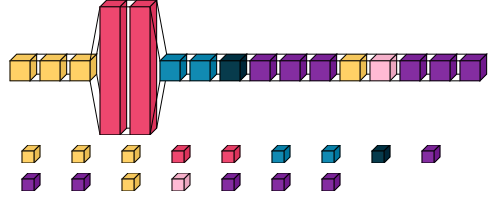

In [39]:
import visualkeras

# Visualize your Keras model
visualkeras.layered_view(model, legend=True, draw_volume=True,show_dimension=True)  # Set legend=True for layer names, draw_volume=True for 3D blocks
